In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython import display
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm

In [3]:
np.array([[12,3]]).shape

(1, 2)

# Constants

Adapt paths to local environment!

In [2]:
path2datajson = "/mnt/win_share/MLW/data.json"
path2output = "/mnt/win_share/doc_sec_output/OFA_run_110123/output"
path_images = "/mnt/win_share/MLW/zettel/"

# Data Handling

## Helper Functions

In [3]:
def load_data_json(path: str) -> pd.DataFrame:
    """ Load data.json.

    Load `data.json` file from main data ('MLW') directory.

    :param path: Path to data.json in the  '<drive>/MLW' directory.
    :return: DataFrame of imported data.
    """
    f = open(path)
    data = json.load(f)
    data = pd.DataFrame(data)
    data["length_lemma"] = [len(i) for i in data["lemma"]]
    return data

In [90]:
def load_output(path: str) -> pd.DataFrame:
    """Load and Process Output File.

    Loads and processes output file labeled by the previous visual grounding
    model. Besides coordinates of BBs, length and height are also added to 
    the DataFrame. All BBs, that start at 0.0, 0.0 are dropped and considered
    a failure.

    :param path: Path to output file.
    :return: DataFrame of imported output file. 
    """
    f: any = open(str(path),"r")
    output: list = [json.loads(d) for d in f.readlines()]
    f.close()

    id = [d["file"].split(".")[0] for d in output]
    x1 = [d["result"][0]["box"][0] for d in output]
    y1 = [d["result"][0]["box"][1] for d in output]
    x2 = [d["result"][0]["box"][2] for d in output]
    y2 = [d["result"][0]["box"][3] for d in output]

    outputs_bb = pd.DataFrame(np.array([id,x1,y1,x2,y2]).T, columns=["id","x1","y1","x2","y2"])

    outputs_bb['id'] = outputs_bb['id'].astype("int64")
    outputs_bb['x1'] = round(outputs_bb['x1'].astype("float"))
    outputs_bb['y1'] = round(outputs_bb['y1'].astype("float"))
    outputs_bb['x2'] = round(outputs_bb['x2'].astype("float"))
    outputs_bb['y2'] = round(outputs_bb['y2'].astype("float"))

    # Getting the length and height of the Bounding Boxes
    outputs_bb["length"] = outputs_bb["x2"] - outputs_bb["x1"]
    outputs_bb["height"] = outputs_bb["y2"] - outputs_bb["y1"]

    # Getting area
    outputs_bb["area"] = outputs_bb["length"] * outputs_bb["height"]

    # Removing all BBs with first point at (0,0)
    outputs_bb_df = outputs_bb[(outputs_bb["x1"]!=0) & (outputs_bb["y1"]!=0)].copy()
    return outputs_bb_df

In [76]:
def create_dataset(path2datajson: str, path2output: str) -> pd.DataFrame:
    """Create Dataset to Label.
    
    Function to merge output and data.json datasets. Both datasets are
    first loaded and subsequently merged.
    
    :param path2datajson: Path to `data.json` file.
    :param path2output: Path to `output` file.
    :return: Merged Dataset.
    """
    datajson: pd.DataFrame = load_data_json(path2datajson)
    dataoutput: pd.DataFrame = load_output(path2output)
    data: pd.DataFrame = datajson.merge(dataoutput, on="id")
    return data

# Main

In [91]:
df = create_dataset(
    path2datajson=path2datajson,
    path2output=path2output)

In [92]:
df

,id,lemma,length_lemma,x1,y1,x2,y2,length,height,area
0,962,kalendae,8,199.0,52.0,602.0,196.0,403.0,144.0,58032.0
1,966,kalendae,8,62.0,18.0,483.0,157.0,421.0,139.0,58519.0
2,983,kalendae,8,146.0,74.0,556.0,172.0,410.0,98.0,40180.0
3,1026,kalendae,8,47.0,10.0,430.0,152.0,383.0,142.0,54386.0
4,1040,kalendae,8,62.0,13.0,429.0,154.0,367.0,141.0,51747.0
...,...,...,...,...,...,...,...,...,...,...
4019,308406,nimis,5,73.0,5.0,459.0,169.0,386.0,164.0,63304.0
4020,308537,nimis,5,26.0,10.0,327.0,153.0,301.0,143.0,43043.0
4021,308540,nimis,5,19.0,41.0,308.0,155.0,289.0,114.0,32946.0
4022,308571,nimium,6,72.0,10.0,511.0,171.0,439.0,161.0,70679.0


In [36]:
def get_outliers(data, column: str) -> pd.DataFrame:
    q1 = data[column].quantile(0.25)
    q3= data[column].quantile(0.75)
    IQR = q3 - q1
    data["outliers_" + column] = ["yes" if ((d<(q1-1.5*IQR)) | (d>(q3+1.5*IQR))) else "no" for d in data[column]]
    return data

In [116]:
def get_outliers_(data) -> pd.DataFrame:
    q1_height = data['y1'].quantile(0.25)
    q3_height = data['y1'].quantile(0.75)
    IQR_height = q3_height - q1_height

    q1_width = data['x1'].quantile(0.25)
    q3_width = data['x1'].quantile(0.75)
    IQR_width = q3_width - q1_width
    data["outliers"] = ["yes" if (((height < (q1_height + 1.5*IQR_height)) | (height>(q3_height+1.5*IQR_height))) & ((length<(q1_width-1.5*IQR_width)) | (length>(q3_width+1.5*IQR_width)))) else "no" for (height, length) in data[['height', 'length']].values]
    return data

In [62]:
df[['height', 'length']]

,height,length
0,144.0,403.0
1,139.0,421.0
2,98.0,410.0
3,142.0,383.0
4,141.0,367.0
...,...,...
4019,164.0,386.0
4020,143.0,301.0
4021,114.0,289.0
4022,161.0,439.0


In [ ]:
[(e1, e2) for (e1, e2) in df[['height', 'length']].values]

In [43]:
lemma_length: list = df['length_lemma'].unique()
df[df['length_lemma']== 2]['height'].quantile(0.25), df[df['length_lemma']== 2]['height'].quantile(0.75)

(76.0, 154.25)

In [97]:
df_out_area = get_outliers(df.copy(), 'area')

In [98]:
len(df_out_area[df_out_area["outliers_" + "area"] == 'yes']) / len(df_out_area)

0.019135188866799206

In [52]:
df_out = get_outliers(df[df['length_lemma']== 6].copy(), 'height')

In [49]:
len(df_out[df_out["outliers_" + "height"] == 'yes']) / len(df_out)

0.014705882352941176

In [50]:
def vis_cluster_sample(
        data: pd.DataFrame,
        columns: int=4,
        rows: int=5,
        w: int=40,
        h: int=40):

    # fig = plt.figure(figsize=(w, h))

    # Sample
    if len(data) < columns * rows:
        X = data
    else:
        indices = np.random.choice(range(len(data)), columns * rows)
        X = data.iloc[indices]

    # Get Images
    images: list = list()
    for _, e in X.iterrows():
        img = np.asarray(Image.open(os.path.join(path_images, str(e['id']) + '.jpg'), mode="r"))
        cv2.rectangle(
            img,
            (int(e['x1']), int(e['y1'])),
            (int(e['x2']), int(e['y2'])),
            (0, 255, 0),
            3
        )
        images.append(img)

    # Process Images
    dims = list(map(lambda e: e.shape, images))
    size_height, size_width = tuple(map(lambda e: min(e), [list(t) for t in zip(*dims)][0:2]))
    images_cropped = list(map(lambda e: e[0:size_height, 0:size_width], images))

    fig, axs = plt.subplots(rows, columns, figsize=(w, h), constrained_layout=True,
                        sharex=True, sharey=True)

    # for index, e in enumerate(images_cropped):
    #     img = Image.fromarray(e)
    #     fig.add_subplot(rows, columns, index + 1, label = "test")
    #     plt.imshow(img)

    for i, ax in enumerate(axs.flat):
        ax.imshow(Image.fromarray(images_cropped[i]))
        ax.set_title(
            str(X['id'].values[i]) + '.jpg',
            fontsize='small',
            loc='left')
    
    plt.show()

In [ ]:
vis_cluster_sample(df_out[df_out["outliers_" + "height"] == 'yes'])

Remove hieght annd width outliers
Remove y1 outliers annd x1 outliers 

In [ ]:
vis_cluster_sample(df_out_[df_out_["outliers"] == 'yes'])

In [ ]:
vis_cluster_sample(df_out_area[df_out_area["outliers_" + "area"] == 'yes'])

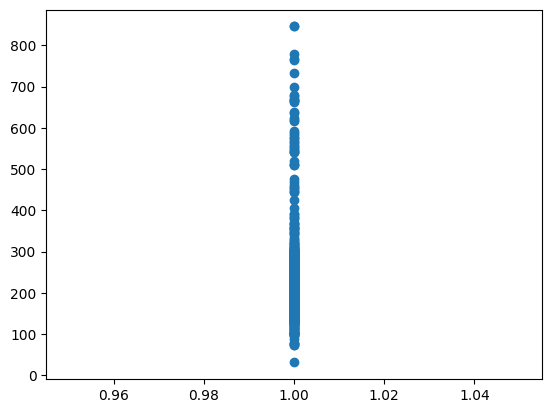

In [86]:
e = df_out_area['area'].values
plt.scatter(np.array([1] * len(e)), e)

In [102]:
MAX_WIDTH = 1750 / 2
MAX_HEIGHT = 1200 / 2

In [100]:
df['area'].max()

2030112.0

In [104]:
MAX_AREA = MAX_WIDTH * MAX_HEIGHT

In [107]:
df_rule_based = df[df['area'] > MAX_AREA]

In [ ]:
vis_cluster_sample(df_rule_based)

In [ ]:
vis_cluster_sample(df_out_area[df_out_area["outliers_" + "area"] == 'yes'])

In [117]:
df_out_ = get_outliers_(df.copy())

In [ ]:
vis_cluster_sample(df_out_[df_out_["outliers"] == 'yes'])